# Identifying safe loans with decision trees

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_%28finance%29).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Use pandas to do some feature engineering.
* Train a decision-tree on the LendingClub dataset.
* Visualize the tree.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

Let's get started!

## Fire up Scikit-learn, Pandas and Numpy

In [2]:
import pandas as pd
import numpy as np
from sklearn import datasets

# Load LendingClub dataset


We will be using a dataset from the [LendingClub](https://www.lendingclub.com/). A parsed and cleaned form of the dataset is availiable [here](https://github.com/learnml/machine-learning-specialization-private). Make sure you **download the dataset** before running the following command.

In [3]:
loans = pd.read_csv('lending-club-data.csv')

/Users/yunpeng/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [4]:
list(loans)

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'is_inc_v',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'not_compliant',
 'status',
 'inactive_loans',
 'bad_loans',
 'emp_length_num',
 'grade_num',
 'sub_grade_num',
 'delinq_2yrs_zero',
 'pub_rec

Here, we should see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc.

In [5]:
#loans['grade'].apply(pd.value_counts).T.stack().plot(kind='bar')

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [6]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', 1)
loans['safe_loans'].head()

0    1
1   -1
2    1
3    1
4    1
Name: safe_loans, dtype: int64

Now, let us explore the distribution of the column `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset.

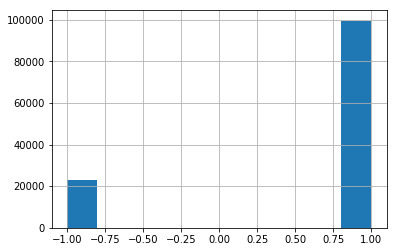

In [7]:
import matplotlib.pyplot as plt
loans['safe_loans'].hist(bins=10)
plt.show()
plt.close()

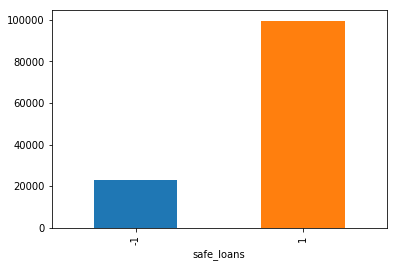

In [8]:
# Plot for a categorical column
loans.groupby('safe_loans').size().plot(kind='bar')
plt.show()
plt.close()

You should have:
* Around 81% safe loans
* Around 19% risky loans

It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

## Features for the classification algorithm

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [9]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

What remains now is a **subset of features** and the **target** that we will use for the rest of this notebook. 

## Split data into training and validation sets

We split the data into training and validation sets using an 80/20 split and specifying `seed=1` so everyone gets the same results.

**Note**: In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters** (this is known as model selection). Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

Then follow the following steps:

Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding. Alternatively, see #7 for implementation hints.

Load the JSON files into the lists train_idx and validation_idx.

Perform train/validation split using train_idx and validation_idx. In Pandas, for instance:

One-hot encoding

7.. For scikit-learn's decision tree implementation, it requires numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding. The next assignment has more details about this.

In [10]:
temp_loans=pd.get_dummies(loans)
temp_loans.head()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0,11,27.65,1,1,83.7,0.00,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1.00,1,1,9.4,0.00,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,11,8.72,1,1,98.5,0.00,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,11,20.00,0,1,21.0,16.97,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,4,11.20,1,1,28.3,0.00,1,1,0,...,0,0,0,0,0,0,0,1,1,0


In [11]:
#read the index documents
train_idx = pd.read_json('module-5-assignment-1-train-idx.json')
validation_idx = pd.read_json('module-5-assignment-1-validation-idx.json')

In [12]:
#pull train and test data from products data using the index docs
train_data = temp_loans.loc[train_idx.values.reshape((-1,))]
validation_data = temp_loans.loc[validation_idx.values.reshape((-1,))]
train_data.shape

(37224, 68)

In [13]:
# test another way to pull validation data
valid_data=temp_loans.loc[validation_idx[0]]
valid_data.shape

(9284, 68)

# Use decision tree to build a classifier

9.. Now, let's use the built-in scikit learn decision tree learner (sklearn.tree.DecisionTreeClassifier) to create a loan prediction model on the training data. To do this, you will need to import sklearn, sklearn.tree, and numpy.

Note: You will have to first convert the SFrame into a numpy data matrix, and extract the target labels as a numpy array (Hint: you can use the .to_numpy() method call on SFrame to turn SFrames into numpy arrays). See the API for more information. Make sure to set max_depth=6.

In [14]:
output_train=train_data['safe_loans']
ft=train_data.columns
ft=ft.drop('safe_loans')

In [15]:
from sklearn import tree
decision_tree_model=tree.DecisionTreeClassifier(max_depth=6)
decision_tree_model.fit(train_data[ft],output_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

10.. Also train a tree using with max_depth=2. Call this model small_model.

In [16]:
small_model=tree.DecisionTreeClassifier(max_depth=2)
small_model.fit(train_data[ft],output_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Visualizing a learned model (Optional)

10a.. For this optional section, we would like to see what the small learned tree looks like. If you are using scikit-learn and have the package Graphviz, then you will be able to perform this section. If you are using a different software, try your best to follow along.

Visualize small_model in the software of your choice.

In [17]:
import graphviz

In [18]:
dot_data=tree.export_graphviz(small_model,out_file=None,feature_names=train_data[ft].columns,rounded=True)

In [19]:
graph=graphviz.Source(dot_data)

In [20]:
print(graph)

## Making predictions

Let's consider two positive and two negative examples from the validation set and see what the model predicts. We will do the following:

Predict whether or not a loan is safe.

Predict the probability that a loan is safe.

11.. First, let's grab 2 positive examples and 2 negative examples. 

In [21]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
print(sample_validation_data.shape)
sample_validation_data_ft = sample_validation_data[sample_validation_data.columns.difference(['safe_loans'])]
sample_validation_data_tt = sample_validation_data['safe_loans']
sample_validation_data_ft
sample_validation_data_tt

(4, 68)


19    1
79    1
24   -1
41   -1
Name: safe_loans, dtype: int64

In [22]:
# use his sample data
sample_out=sample_validation_data['safe_loans']
sample_feat=sample_validation_data[sample_validation_data.columns.drop('safe_loans')]

In [23]:
sample_validation_data_ft.to_csv('sample_validation_data_ft.csv')
sample_feat.to_csv('sample_feat.csv')

In [24]:
# compare sample_validation_data_ft and sample_feat
diff_sample = ((sample_validation_data_ft-sample_feat)**2).sum()
diff_sample[diff_sample !=0]

Series([], dtype: float64)

In [25]:
sample_validation_data_ft.shape

(4, 67)

12.. Now, we will use our model to predict whether or not a loan is likely to default. For each row in the sample_validation_data, use the decision_tree_model to predict whether or not the loan is classified as a safe loan. (Hint: if you are using scikit-learn, you can use the .predict() method)

Quiz Question: What percentage of the predictions on sample_validation_data did decision_tree_model get correct?

In [26]:
decision_tree_model.predict(sample_validation_data_ft)

array([-1, -1, -1,  1])

In [27]:
# for Daniel to check
decision_tree_model.predict(sample_feat)

array([ 1, -1, -1,  1])

In [28]:
print('Answer: the percentage of the predictions on sample_validation_data did decision_tree_model get correct:50%' )

Answer: the percentage of the predictions on sample_validation_data did decision_tree_model get correct:50%


## Explore probability predictions

13.. For each row in the sample_validation_data, what is the probability (according decision_tree_model) of a loan being classified as safe? (Hint: if you are using scikit-learn, you can use the .predict_proba() method)

Quiz Question: Which loan has the highest probability of being classified as a safe loan?

In [29]:
sample_validation_data_ft

,dti,emp_length_num,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,...,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,term_ 36 months,term_ 60 months,total_rec_late_fee
19,11.18,11,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
79,16.85,10,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
24,13.97,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
41,16.33,11,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0.0


In [30]:
decision_tree_model.predict_proba(sample_validation_data_ft)

array([[ 0.53630646,  0.46369354],
       [ 0.53630646,  0.46369354],
       [ 0.53630646,  0.46369354],
       [ 0.4440545 ,  0.5559455 ]])

In [31]:
decision_tree_model.classes_

array([-1,  1])

In [32]:
# calculate prediction probability using sample_feat
print(decision_tree_model.predict_proba(sample_feat))
print(decision_tree_model.classes_)
print(decision_tree_model.predict(sample_feat))
print(sample_out)

[[ 0.34156543  0.65843457]
 [ 0.53630646  0.46369354]
 [ 0.64750958  0.35249042]
 [ 0.20789474  0.79210526]]
[-1  1]
[ 1 -1 -1  1]
19    1
79    1
24   -1
41   -1
Name: safe_loans, dtype: int64


In [33]:
print('Answer: ', 'The fourth loan has the highest probability of being classified as a safe loan')

Answer:  The fourth loan has the highest probability of being classified as a safe loan


Checkpoint: Can you verify that for all the predictions with probability >= 0.5, the model predicted the label +1?

In [34]:
print('Answer: Yes')

Answer: Yes


## Tricky predictions!

14.. Now, we will explore something pretty interesting. For each row in the sample_validation_data, what is the probability (according to small_model) of a loan being classified as safe?

Quiz Question: Notice that the probability preditions are the exact same for the 2nd and 3rd loans. Why would this happen?

In [35]:
small_model.predict_proba(sample_validation_data_ft)

array([[ 0.59255339,  0.40744661],
       [ 0.59255339,  0.40744661],
       [ 0.59255339,  0.40744661],
       [ 0.59255339,  0.40744661]])

In [36]:
# calculate prediction probability using sample_feat
small_model.predict_proba(sample_feat)

array([[ 0.41896585,  0.58103415],
       [ 0.59255339,  0.40744661],
       [ 0.59255339,  0.40744661],
       [ 0.23120112,  0.76879888]])

In [37]:
small_model.classes_

array([-1,  1])

## Visualize the prediction on a tree

Quiz Question: Based on the visualized tree, what prediction would you make for this data point (according to small_model)? (If you don't have Graphviz, you can answer this quiz question by executing the next part.)

15.. Now, verify your prediction by examining the prediction made using small_model.

# Evaluating accuracy of the decision tree model

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data

16.. Evaluate the accuracy of small_model and decision_tree_model on the training data. (Hint: if you are using scikit-learn, you can use the .score() method)

Checkpoint: You should see that the small_model performs worse than the decision_tree_model on the training data.

In [38]:
decision_tree_model.score(train_data[ft],output_train)

0.64052761659144641

In [39]:
small_model.score(train_data[ft],output_train)

0.61350204169353106

17.. Now, evaluate the accuracy of the small_model and decision_tree_model on the entire validation_data, not just the subsample considered above.

Quiz Question: What is the accuracy of decision_tree_model on the validation set, rounded to the nearest .01?

In [40]:
output_valid=validation_data['safe_loans']
ftv=validation_data.columns
ftv=ftv.drop('safe_loans')
ftv.shape

(67,)

In [41]:
print('Answer: the accurray of decision_tree_model on the vaidation set', np.round(decision_tree_model.score(validation_data[ftv],output_valid),2))

Answer: the accurray of decision_tree_model on the vaidation set 0.64


In [42]:
print('Answer: the accurray of small_model on the vaidation set', np.round(small_model.score(validation_data[ftv],output_valid),2))

Answer: the accurray of small_model on the vaidation set 0.62


## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

18.. Using sklearn.tree.DecisionTreeClassifier, train a decision tree with maximum depth = 10. Call this model big_model.

19.. Evaluate the accuracy of big_model on the training set and validation set.

In [43]:
big_model=tree.DecisionTreeClassifier(max_depth=10)
big_model.fit(train_data[ft],output_train)
big_model.score(train_data[ft],output_train)

0.66379217709004945

In [44]:
big_model.score(validation_data[ftv],output_valid)

0.62634640241275308

In [45]:
# test another way to calculate accurray score for big model based on validation data
score2 = big_model.score(valid_data[valid_data.columns.drop('safe_loans')],valid_data['safe_loans'])
score2

0.62634640241275308

Checkpoint: We should see that big_model has even better performance on the training set than decision_tree_model did on the training set.

Quiz Question: How does the performance of big_model on the validation set compare to decision_tree_model on the validation set? Is this a sign of overfitting?

In [46]:
print('Answer: yes')

Answer: yes


### Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.

Assume the following:

* **False negatives**: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of losing a loan that would have otherwise been accepted. 
* **False positives**: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given. 
* **Correct predictions**: All correct predictions don't typically incur any cost.


Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:
1. First, let us compute the predictions made by the model.
1. Second, compute the number of false positives.
2. Third, compute the number of false negatives.
3. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

Quiz Question: Let's assume that each mistake costs us money: a false negative costs $10,000, while a false positive positive costs $20,000. What is the total cost of mistakes made by decision_tree_model on validation_data?

First, let us make predictions on `validation_data` using the `decision_tree_model`:

In [47]:
output_valid=validation_data['safe_loans']
ftv=validation_data.columns
ftv=ftv.drop('safe_loans')

In [48]:
predictions = decision_tree_model.predict(validation_data[ftv])
predictions.shape

(9284,)

In [49]:
# another way to make prediction - based on valid data
predictions2 = decision_tree_model.predict(valid_data[valid_data.columns.drop('safe_loans')])

**False positives** are predictions where the model predicts +1 but the true label is -1. Complete the following code block for the number of false positives:

In [50]:
diff = predictions-output_valid
diff.head()

24     0
41     2
60     0
93     0
132    2
Name: safe_loans, dtype: int64

In [54]:
from collections import Counter
counter = Counter(diff)
print(counter)

Counter({0: 5906, -2: 1717, 2: 1661})


In [57]:
# My first way to calcualte false positives based on validation data
counter.get(2)

1661

In [ ]:
# My second way to calculate false positives based on validation data
false_pos=np.sum((predictions==1)&(output_valid==-1))
false_pos

In [ ]:
# Another way to calculate false negatives based on valid data
false_pos2=np.sum((predictions2==1)&(valid_data['safe_loans']==-1))
false_pos2

**False negatives** are predictions where the model predicts -1 but the true label is +1. Complete the following code block for the number of false negatives:

In [ ]:
# My first way to calcualte false negatives based on validation data
counter.get(-2)

In [ ]:
# My second way to calculate false negatives based on validation data
false_neg=np.sum((predictions==-1)&(output_valid==1))
false_neg

In [ ]:
# Another way to calculate false negatives based on valid data
false_neg2=np.sum((predictions2==-1)&(valid_data['safe_loans']==1))
false_neg2

In [ ]:
cost = (false_pos*20000)+(false_neg*10000)
print('Answer: the cost is: ', cost)